In [1]:
# Loading required libraries
library(ggplot2)
library(tidyr)
library(dplyr)
library(stringr)
library(scales)
library(RColorBrewer)
library(rjson)
library(ggpubr)

theme_set(theme_bw())

# If TRUE, the raw data will be loaded
REGENERATE_DATA = FALSE
options(warn=-1)

Runs = 30


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Part 1 - Estimator Evaluation

## Crunch Fuzztastic and Fuzzbench Data

Generates and/or loads `data/fuzztastic_data.Rda` fuzzing data to the memory. 

* Fuzztastic data will be loaded as ```fuzztastic```. (as an R data frame)

Specifically, .json files that were written one in every 15 mins during the fuzzing campaign are loaded and arranged in this data frame.

In [2]:
if (REGENERATE_DATA) {
  loaded = FALSE
  folder = "../data/fuzztastic_data_raw/"

  for(subject in list.files(folder)) {
    for (run in seq(1, Runs)) {
      i = 0
      dir = paste(
        folder, subject, "/seed_01/aflpp_seed_01_run_",
        str_pad(run, 2, "left", "0"), "/", sep = ""
      )

      start = as.integer(substr(str_split(sort(list.files(dir))[1],"_")[[1]][3],1,10))
      time_since_start = 900
      time_overall = start + 900
      while (TRUE) {
        found_it = FALSE
        for (i in seq(0, 20)) {
          f1 = paste(dir, "ft_cov_", time_overall + i, ".json", sep = "")
          f2 = paste(dir, "ft_cov_", time_overall - i, ".json", sep = "")
          if (file.exists(f1)) {
            t = as.data.frame(fromJSON(file = f1))
            time_overall = time_overall + i
            found_it = TRUE
            break
          } else if (file.exists(f2)) {
            t = as.data.frame(fromJSON(file = f2))
            time_overall = time_overall - i
            found_it = TRUE
            break
          }
        }
        if (!found_it) {
          break
        }

        # We know that there are 8 calibrations runs happened during the fuzzing campaign. 
        # We correct frequencies for that.
        Sn  = sum(t$block_coverage > 0)
        f1  = sum(t$block_coverage == 9)  # 8 calibration runs.
        f2  = sum(t$block_coverage == 10) # 8 calibration runs.
        f3  = sum(t$block_coverage == 11) # 8 calibration runs.
        f4  = sum(t$block_coverage == 12) # 8 calibration runs.
        f5  = sum(t$block_coverage == 13) # 8 calibration runs.
        f6  = sum(t$block_coverage == 14) # 8 calibration runs.
        f7  = sum(t$block_coverage == 15) # 8 calibration runs.
        f8  = sum(t$block_coverage == 16) # 8 calibration runs.
        f9  = sum(t$block_coverage == 17) # 8 calibration runs.
        f10 = sum(t$block_coverage == 18) # 8 calibration runs.
        max = max(t$block_coverage)
        min = min(subset(t, block_coverage > 0)$block_coverage)
        type  = c("Sn", "f1", "f2", "f3", "f4", "f5", "f6", "f7",
                  "f8", "f9", "f10", "max", "min")
        value = c(Sn, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, max, min)

        # TODO Enable when we have more than 1 fuzzer
        # max = max(t$block_coverage)
        # # p_i, but not normalized to avoid floating point inaccuracies.
        # p = subset(t,block_coverage>0)$block_coverage / max
        # for (q in c(-2, -1, 0, 1, 2)) {
        #   Type = c(Type, paste("q =",q))
        #   if (i == 0) Value = c(Value, 0)
        #   else if (q != 1) {
        #     Value = c(Value, sum(p ^ q) ^ (1 / (1 - q)))
        #   } else {
        #     # Missing the exponential due to overflow potential.
        #     # But rankings should be unaffected.
        #     Value = c(Value, - sum(p * log(p))) 
        #   }
        # }

        n = data.frame(type, value)
        n$time = time_since_start
        n$run = run
        n$subject = subject
        if (!loaded) {
          fuzztastic = n
          loaded = TRUE
        }
        else {
          fuzztastic = rbind(fuzztastic, n)
        }

        time_overall = time_overall + 900
        time_since_start = time_since_start + 900
      }
    }
  }

  save(fuzztastic, file="../data/fuzztastic_data.Rda")
  
} else {

  load(file="../data/fuzztastic_data.Rda")

}

# Align each run with 7 days of fuzzing data
fuzztastic = fuzztastic %>% 
  filter(time <= 170 * 3600)

tail(fuzztastic, n = 10)

,type,value,time,run,subject
,<fct>,<dbl>,<dbl>,<int>,<chr>
1591191,f3,12,612000,30,readelf
1591192,f4,12,612000,30,readelf
1591193,f5,5,612000,30,readelf
1591194,f6,0,612000,30,readelf
1591195,f7,0,612000,30,readelf
1591196,f8,0,612000,30,readelf
1591197,f9,1,612000,30,readelf
1591198,f10,32,612000,30,readelf
1591199,max,132716919,612000,30,readelf


## Filtering Outlying Runs

We look at the basic bloack (BB) accumulation for each run (trial) as a sanity check.

Below plot showed that some of the very few accumulation curves achieve more BBs. We exclude those 1 or 2 outlying runs to better understand the average behaviour.

* Output name - ```sanity_check.pdf```.

Saving 6.67 x 6.67 in image



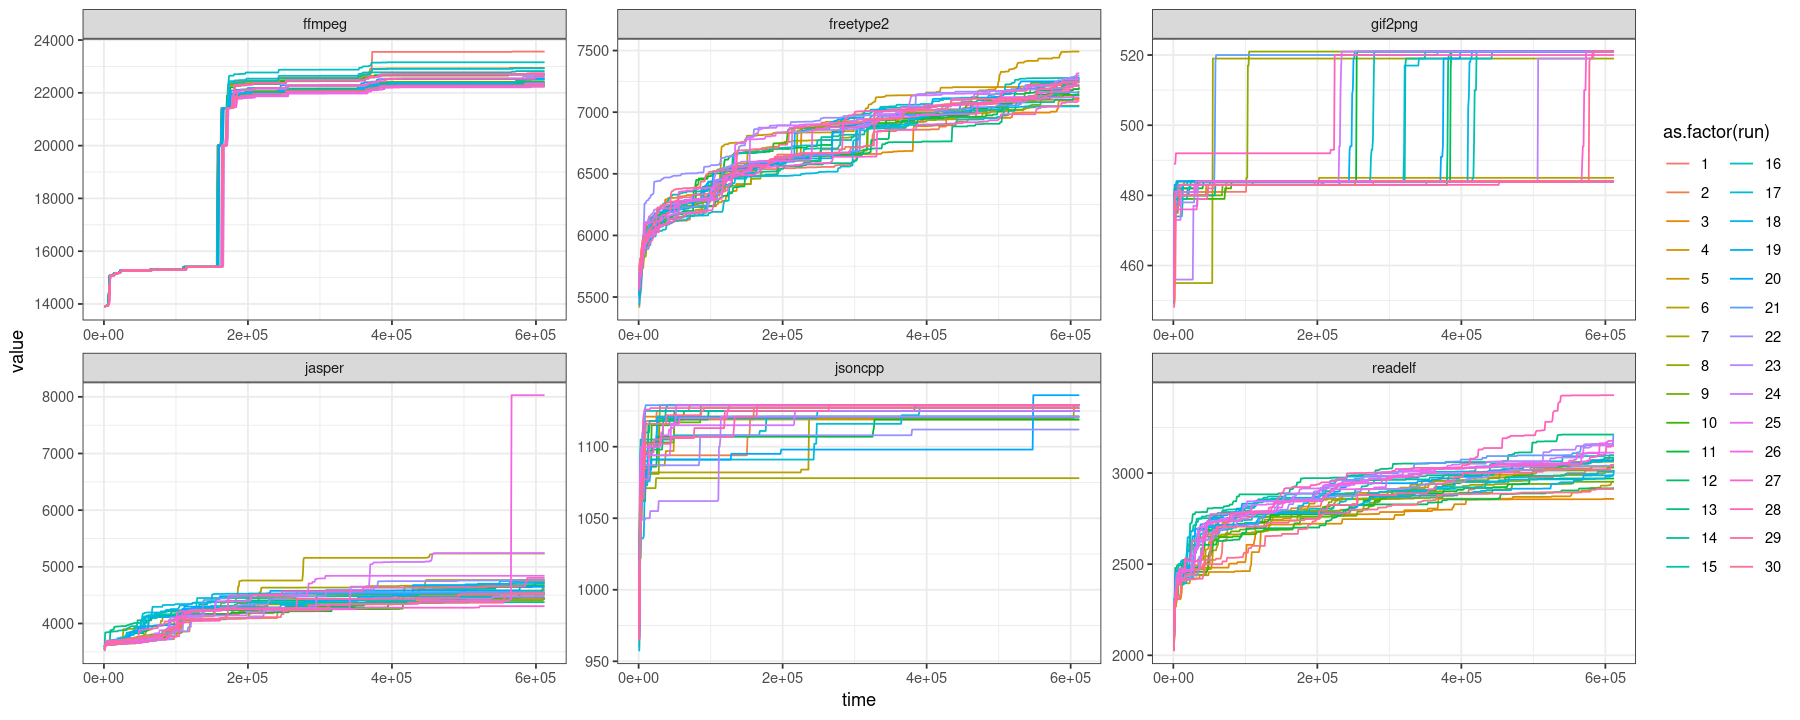

In [3]:
# Trial wise species accumulation
options(repr.plot.width = 15, repr.plot.height = 6)
fuzztastic %>% filter(type=="Sn") %>%
ggplot() +
geom_line(aes(time,value, color=as.factor(run))) +
facet_wrap(~subject, scale="free") 

# Save plot
ggsave(file="../figures/sanity_check.pdf")

In [4]:
# Filter out outlying runs
exclude_runs = unique((fuzztastic %>% filter(subject=="jasper" & type=="Sn" & value>5000))$run)
fuzztastic = fuzztastic %>% filter(!(subject=="jasper" & run %in% exclude_runs))

## Empirical BB Accumulation

We plot the mean BB accumulation curve for each subject in our fuzztastic fuzzing campaigns.

* The resulting plot is the ```Figure 5(b)``` in the paper. 

`summarise()` has grouped output by 'subject'. You can override using the `.groups` argument.

Saving 5.33 x 3.2 in image



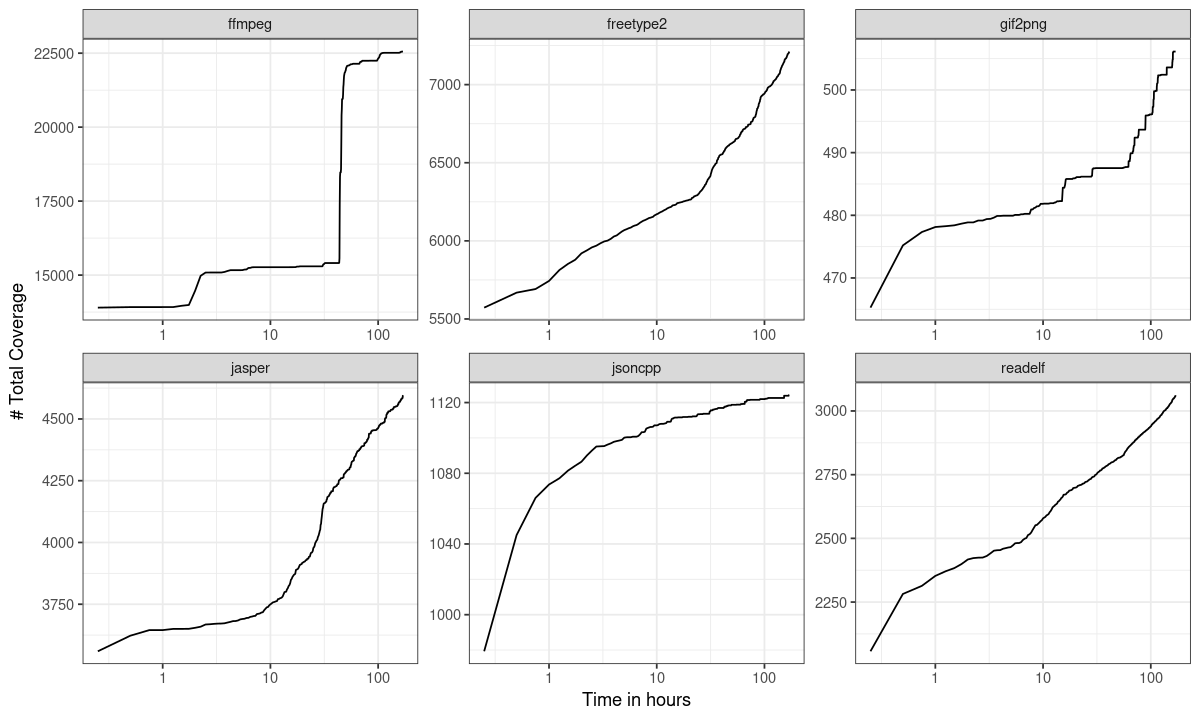

In [5]:
# Plot empirical BB accumulation curves
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(fuzztastic %>% 
         filter(type == "Sn") %>%
         group_by(subject,time) %>%
         summarize(value = mean(value))
) +
  geom_line(aes(time / 3600, value)) +
  scale_x_log10(name = "Time in hours") +
  scale_y_continuous(name = "# Total Coverage") +
  facet_wrap(~subject, scales = "free", nrow = 2)

ggsave(file="../figures/Figure-5b.pdf", scale = 0.8, height = 4)

## RQ2: Evaluate Estimator Performance

We evaluate the performance of the estimators of fuzzer effectiveness given in ```Figure2``` in the paper.

Namely, 1) Chao2, 2) Chao2-bias corrected, 3) iChao2, 4) ICE, 5) ICE-1, 6) Jackknife-1, and 7) Jackknife-2

* These estimates appear in ```Figure 6``` through the table we generate here.

In [6]:
# Compute effectiveness estimates.

datapoints = c(
    900,            # 15 min
    3 * 3600,       # 3 hours
    24 * 3600,      # 1 day
    7 * 24 * 3600)  # 1 week

time2text = function(Time) {
  if (Time == 900) return("15 min")
  if (Time == 3 * 3600) return("3 hrs")
  if (Time == 24 * 3600) return("1 day")
  if (Time == 7 * 24 * 3600) return("1 week")
  return("Unknown")
}

cat("% This file is auto-generated.\n", file = "../figures/Figure-6.tex")
for (Subject in levels(factor(fuzztastic$subject))) {
  cat("\\multirow{", length(datapoints),"}{*}{", Subject, "}",
      sep = "", file = "../figures/Figure-6.tex", append = TRUE)
  for (Time in datapoints) {
    cat(" & ",time2text(Time), sep="", file="../figures/Figure-6.tex", append=TRUE)
    t = subset(fuzztastic, subject == Subject & time == Time) %>% spread(type, value)
    Sn  = t$Sn
    n   = t$max
    f1  = t$f1
    f2  = t$f2
    f3  = t$f3
    f4  = t$f4
    f5  = t$f5
    f6  = t$f6
    f7  = t$f7
    f8  = t$f8
    f9  = t$f9
    f10 = t$f10
    # https://www.uvm.edu/~ngotelli/manuscriptpdfs/Chapter%204.pdf
    chao2 = Sn + ifelse(f2 == 0,
                        ((n-1)/n)*((f1*(f1-1))/2),
                        ((n-1)/n)*((f1^2)/(2*f2)))
    #chao2 = Sn + ifelse(f2 == 0, 0, (f1 * f1 / (2 * f2)))
    chao2_bc = Sn + f1 * (f1 - 1) / (2 * (f2 + 1))
    iChao2 = chao2 + 
      ifelse(f4 == 0, 0, 
            (f3 / (4 * f4)) * (f1 - ((f2 * f3) / (2 * f4))))
    jk1 = Sn + f1 * (n - 1) / n
    jk2 = Sn + (f1 * (2 * n - 3) / n) - (f2 * (n - 2)^2 / (n * (n - 1)))

    Sinfr = f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10
    Sfreq = Sn - Sinfr
    ninfr = 1 * f1 + 2 * f2 + 3 * f3 + 4 * f4 +  5 * f5 +
            6 * f6 + 7 * f7 + 8 * f8 + 9 * f9 + 10 * f10
    CICE  = 1 - ifelse(ninfr == 0, 0, f1 / ninfr)
    sum1  =  2 * f2 +  6 * f3 + 12 * f4 + 20 * f5 + 
            30 * f6 + 42 * f7 + 56 * f8 + 72 * f9 + 90 * f10
    gamma = ifelse(CICE == 0 | ninfr == 0 | sum1 == 0, 0,
            Sinfr / CICE * ninfr / (ninfr - 1) * sum1 / (ninfr * ninfr) - 1)
    gamma = ifelse(gamma < 0, 0, gamma)
    SICE  = Sfreq + Sinfr / CICE + f1 / CICE * gamma

    gamma_curl = ifelse(CICE == 0 | ninfr == 0 | sum1 == 0, 0,
      gamma * (1 + (ninfr * (1 - CICE)) / (ninfr * (ninfr - 1) * CICE)))
    gamma_curl = ifelse(gamma_curl < 0, 0, gamma_curl)
    SICE1 = Sfreq + Sinfr / CICE + f1 / CICE * gamma_curl

    cat(" & ", format(round(mean(Sn), 0), nsmall = 0),
        " & ", format(round(mean(chao2, na.rm = TRUE), 0), nsmall = 0), 
        " & ", format(round(mean(chao2_bc), 0), nsmall = 0),
        " & ", format(round(mean(iChao2, na.rm = TRUE), 0), nsmall = 0),
        " & ", format(round(mean(SICE, na.rm = TRUE), 0), nsmall = 0),
        " & ", format(round(mean(SICE1, na.rm = TRUE), 0), nsmall = 0),
        " & ", format(round(mean(jk1), 0), nsmall = 0),
        " & ", format(round(mean(jk2), 0), nsmall = 0),
        sep = "", file="../figures/Figure-6.tex", append=TRUE)
    cat("\\\\\n", sep = "", file = "../figures/Figure-6.tex", append=TRUE)
  }
  cat("\\hline\n", sep = "", file = "../figures/Figure-6.tex", append=TRUE)
}
sink()

## RQ1: How often we can observe asymptote?

We consider 7 day long fuzzing trials from Fuzzbench and construct bench accumulation curves for multiple fuzzers and subjects.

* Fuzzbench 1 week long campaign data will be loaded as ```fuzzbench7d```

In [7]:
# Loading extracted data from fuzzbench.

experiments = c(
  "2021-04-11-7d-paper",
  "2021-04-23-7d-paper",
  "2021-07-10-redo-7d",
  "2021-08-19-crash-s-7d")

# Download fuzzbench coverage data.
fuzzbench_load <- function(Experiment) {
  url = paste("https://www.fuzzbench.com/reports/",Experiment,"/data.csv.gz",sep="")
  tmp <- tempfile()
  download.file(url,tmp)
  data <- read.csv(
    gzfile(tmp),
    sep=",",
    header=TRUE,
    stringsAsFactors=FALSE)

  return(subset(data,experiment == Experiment))
}

if (REGENERATE_DATA) {
#if (TRUE) {

  fuzzbench7d = fuzzbench_load(experiments[1])
  for (experiment in tail(experiments,-1)) {
    fuzzbench7d = rbind(fuzzbench7d, fuzzbench_load(experiment))
  }
  save(fuzzbench7d, file="../data/fuzzbench_remote_data.Rdata")

} else {

  load(file="../data/fuzzbench_remote_data.Rdata")

  # Delete me.
  fuzzbench7d = data

}

# Print fuzzers, subjects, and experiments in data.
levels(factor(fuzzbench7d$experiment))
levels(factor(fuzzbench7d$benchmark))
levels(factor(fuzzbench7d$fuzzer))
t = fuzzbench7d %>% 
  group_by(trial_id) %>% 
  summarize(max_time = max(time)) %>%
  group_by() %>%
  summarize(total_time = sum(max_time))
paste(t$total_time / 3600 / 24 / 365, "CPU years")

head(fuzzbench7d)


[1] "2021-04-11-7d-paper"   "2021-04-23-7d-paper"   "2021-07-10-redo-7d"   
[4] "2021-08-19-crash-s-7d"

[1] "arrow_parquet-arrow-fuzz"         "bloaty_fuzz_target"              
 [3] "curl_curl_fuzzer_http"            "ffmpeg_ffmpeg_demuxer_fuzzer"    
 [5] "freetype2-2017"                   "harfbuzz-1.3.2"                  
 [7] "jsoncpp_jsoncpp_fuzzer"           "lcms-2017-03-21"                 
 [9] "libarchive_libarchive_fuzzer"     "libjpeg-turbo-07-2017"           
[11] "libpcap_fuzz_both"                "libpng-1.2.56"                   
[13] "libxml2-v2.9.2"                   "libxslt_xpath"                   
[15] "matio_matio_fuzzer"               "mbedtls_fuzz_dtlsclient"         
[17] "ndpi_fuzz_ndpi_reader"            "njs_njs_process_script_fuzzer"   
[19] "openh264_decoder_fuzzer"          "openssl_x509"                    
[21] "openthread-2019-12-23"            "php_php-fuzz-parser"             
[23] "poppler_pdf_fuzzer"               "proj4_standard_fuzzer"           
[25] "proj4-2017-08-14"                 "re2-2014-12-09"                  
[27] "sqlite3_ossfuzz"                  "systemd_fuzz-link-parser"        
[29] "tpm2_tpm2_execute_command_fuzzer" "vorbis-2017-12-11"               
[31] "wireshark_fuzzshark_ip"           "woff2-2016-05-06"                
[33] "zlib_zlib_uncompress_fuzzer"

[1] "afl"         "aflfast"     "aflplusplus" "aflsmart"    "eclipser"   
 [6] "entropic"    "fairfuzz"    "honggfuzz"   "lafintel"    "libfuzzer"  
[11] "mopt"

[1] "116.917579908676 CPU years"

,fuzzer,experiment,benchmark,trial_id,time,edges_covered
,<fct>,<fct>,<fct>,<int>,<int>,<int>
1,afl,2021-04-11-7d-paper,bloaty_fuzz_target,1281882,900,6838
2,afl,2021-04-11-7d-paper,bloaty_fuzz_target,1281882,1800,6941
3,afl,2021-04-11-7d-paper,bloaty_fuzz_target,1281882,2700,7183
4,afl,2021-04-11-7d-paper,bloaty_fuzz_target,1281882,3600,7219
5,afl,2021-04-11-7d-paper,bloaty_fuzz_target,1281882,4500,7536
6,afl,2021-04-11-7d-paper,bloaty_fuzz_target,1281882,5400,7700


We plot the mean branch accumulation curves in log-log scale.

* We prepare the ```Figure-5(a)``` in the paper through below code chunk.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

Saving 6.67 x 10 in image



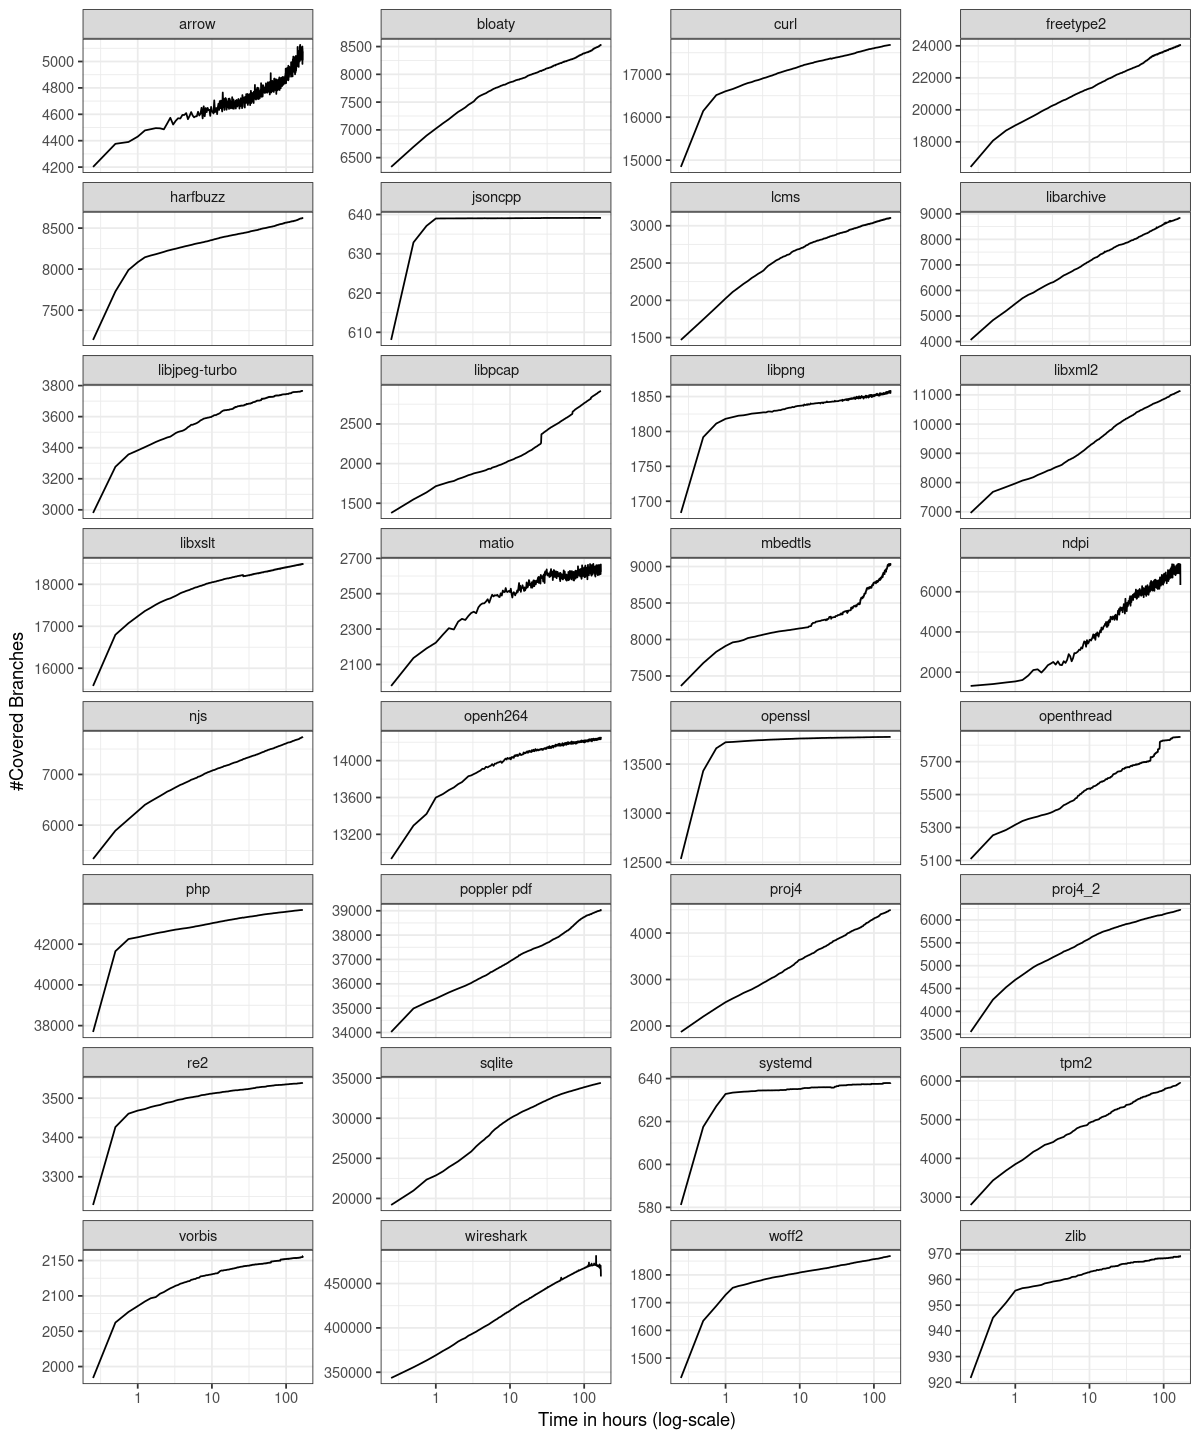

In [8]:
# Convert subject names to short forms.
to_name = function(benchname) {
  if (benchname == "bloaty_fuzz_target") return("bloaty")
  if (benchname == 'curl_curl_fuzzer_http') return("curl")
  if (benchname == 'ffmpeg_ffmpeg_demuxer_fuzzer') return("ffmpeg")
  if (benchname == 'freetype2-2017') return("freetype2")
  if (benchname == 'harfbuzz-1.3.2') return("harfbuzz")
  if (benchname == 'jsoncpp_jsoncpp_fuzzer') return("jsoncpp")
  if (benchname == 'lcms-2017-03-21') return("lcms")
  if (benchname == 'libarchive_libarchive_fuzzer') return("libarchive")
  if (benchname == 'libjpeg-turbo-07-2017') return("libjpeg-turbo")
  if (benchname == 'libpcap_fuzz_both') return("libpcap")
  if (benchname == 'libpng-1.2.56') return("libpng")
  if (benchname == 'libxml2-v2.9.2') return("libxml2")
  if (benchname == 'libxslt_xpath') return("libxslt")
  if (benchname == 'matio_matio_fuzzer') return("matio")
  if (benchname == 'mbedtls_fuzz_dtlsclient') return("mbedtls")
  if (benchname == 'ndpi_fuzz_ndpi_reader') return("ndpi")
  if (benchname == 'njs_njs_process_script_fuzzer') return("njs")
  if (benchname == 'openh264_decoder_fuzzer') return("openh264")
  if (benchname == 'openssl_x509') return("openssl")
  if (benchname == 'openthread-2019-12-23') return("openthread")
  if (benchname == 'php_php-fuzz-parser') return("php")
  if (benchname == 'poppler_pdf_fuzzer') return("poppler pdf")
  if (benchname == 'proj4_standard_fuzzer') return("proj4")
  if (benchname == 'proj4-2017-08-14') return("proj4_2")
  if (benchname == 're2-2014-12-09') return("re2")
  if (benchname == 'sqlite3_ossfuzz') return("sqlite")
  if (benchname == 'systemd_fuzz-link-parser') return("systemd")
  if (benchname == 'tpm2_tpm2_execute_command_fuzzer') return("tpm2")
  if (benchname == 'vorbis-2017-12-11') return("vorbis")
  if (benchname == 'wireshark_fuzzshark_ip') return("wireshark")
  if (benchname == 'woff2-2016-05-06') return("woff2")
  if (benchname == 'zlib_zlib_uncompress_fuzzer') return("zlib")
  
  return(strsplit(benchname,"_")[[1]][1])
}

fuzzbench7dm = fuzzbench7d %>%
  filter(#benchmark != "arrow_parquet-arrow-fuzz") %>% #&
         benchmark != "ffmpeg_ffmpeg_demuxer_fuzzer") %>%
  group_by(benchmark,time) %>%
  summarize(edges_covered = mean(edges_covered)) %>%
  mutate(benchmark = to_name(as.character(benchmark)))

# Plot the results
options(repr.plot.width = 10, repr.plot.height = 12)
ggplot(fuzzbench7dm) +
  geom_line(aes(time / 3600, edges_covered)) +
  ylab("#Covered Branches") +
  scale_x_log10(name="Time in hours (log-scale)") +
  facet_wrap(~benchmark, scales = "free_y", ncol = 4)

ggsave("../figures/Figure-5(a).pdf", scale = 1, height = 10)

# Part 2 - Stopping Rule

To resample from empirical BB distribution, we first need the furthest data file. Therefore, we again load fuzztastic campaign data differently such that we record hit counts for each BB for each subject-run combination.

* The resulting data frome will be named as ```fuzztastic2```.

In [9]:
# Read data such that we have hit counts for distinct BBs
if (REGENERATE_DATA) {
  loaded = FALSE
  folder = "../data/fuzztastic_data_raw/"


  datapoints = c(
    900,            # 15 min
    3 * 3600,       # 3 hours
    24 * 3600,      # 1 day
    7 * 24 * 3600)  # 1 week

  for(subject in list.files(folder)) {
    for (run in seq(1, 30)) {
      #if (subject %in% c("ffmpeg", "freetype2", "jsoncpp") & run <= 10) {
      #  next  Filter broken runs
      # }
      i = 0
      dir = paste(
        folder, subject, "/seed_01/aflpp_seed_01_run_",
        str_pad(run, 2, "left", "0"), "/", sep = ""
      )

      start = as.integer(substr(str_split(sort(list.files(dir))[1],"_")[[1]][3],1,10))
      time_since_start = 900
      time_overall = start + 900
      while (TRUE) {
        found_it = FALSE
        for (i in seq(0, 20)) {
          if (file.exists(paste(dir, "ft_cov_", 
                time_overall + i, 
                ".json", sep = ""))) {
            time_overall = time_overall + i
            found_it = TRUE
            break
          } else if (file.exists(paste(dir, "ft_cov_",
                      time_overall - i,
                      ".json", sep = ""))) {
            time_overall = time_overall - i
            found_it = TRUE
            break
          }
        }
        if (!found_it) {
          break
        }

        # Only record datapoints
        if (! (time_since_start %in% datapoints)) {
          time_overall = time_overall + 900
          time_since_start = time_since_start + 900
          next
        }

        t = as.data.frame(
              fromJSON(file=paste(dir,"ft_cov_",time_overall,".json", sep = "")))
        n = data.frame(
          hits = t$block_coverage,
          bbid = 1:length(t$block_coverage),
          run = run,
          subject = subject,
          time = time_since_start
        )
        if (!loaded) {
          fuzztastic2 = n
          loaded = TRUE
        }
        else {
          fuzztastic2 = rbind(fuzztastic2, n)
        }

        time_overall = time_overall + 900
        time_since_start = time_since_start + 900
      }
    }
  }

  save(fuzztastic2, file="../data/fuzztastic_part2.Rda")

} else {

  load(file="../data/fuzztastic_part2.Rda")

}

tail(fuzztastic2, n = 10)

,hits,bbid,run,subject,time
,<dbl>,<int>,<int>,<fct>,<dbl>
59976111,0,18588,30,readelf,604800
59976112,0,18589,30,readelf,604800
59976113,0,18590,30,readelf,604800
59976114,0,18591,30,readelf,604800
59976115,0,18592,30,readelf,604800
59976116,0,18593,30,readelf,604800
59976117,0,18594,30,readelf,604800
59976118,0,18595,30,readelf,604800
59976119,0,18596,30,readelf,604800


In [10]:
# Filter out outlying runs
fuzztastic2 = fuzztastic2 %>% filter(!(subject=="jasper" & run %in% exclude_runs))

Here we calculate the empirical probability distributions for each run.

* We create the data frame named ```species_distribution```.

In [11]:
species_distribution = fuzztastic2 %>%
  mutate(hits = hits - 8) %>% # account for calibration phase
  filter(hits > 0) %>%
  group_by(subject, time, run) %>%
  mutate(n = sum(hits)) %>%
  mutate(pi = hits / n) %>%                  # probability within run
  group_by(subject, time, bbid) %>%
  summarize(pi = mean(pi), n = mean(n)) %>%  # avg. prob across runs
  group_by(subject, time) %>%
  #mutate(n = n()) %>%
  #filter(pi < 1/n) %>%
  mutate(pi = pi/sum(pi)) # normalize

head(species_distribution)

`summarise()` has grouped output by 'subject', 'time'. You can override using the `.groups` argument.



subject,time,bbid,pi,n
<fct>,<dbl>,<int>,<dbl>,<dbl>
ffmpeg,900,1,9.54491e-05,83940955
ffmpeg,900,2,9.54491e-05,83940955
ffmpeg,900,4,9.54491e-05,83940955
ffmpeg,900,5,9.54491e-05,83940955
ffmpeg,900,6,9.54491e-05,83940955
ffmpeg,900,7,9.54491e-05,83940955


## Resampling-based Investimation of Effectiveness

Through this section, we try to evaluate whether it is possible to estimate fuzzer effectiveness unbiasedly at some point of the suzzing campaign.

* We generate both the paper outputs as ```Figure-7(a)``` and ```Figure-7(b)```.

In [12]:
simulate = function(n, Subject, Time, Type) {
  t = species_distribution %>%
    filter(subject == Subject & time == Time)
  S = sum(t$pi > 0)

  if (Type == "Sn") {
    return(sapply(n, function(m) {
      return(S - sum((1 - t$pi)^m))
    }))
  }
  if (Type == "Gn") {
    return(sapply(n, function(m) {
      return(1 - sum((1 - t$pi)^m)/S)
    }))
  }
  if (Type == "Chao") {
    return(sapply(n, function(m) {
      f1 = (m * sum(t$pi * (1 - t$pi)^(m-1)))
      f2 = (m * (m - 1) / 2 * sum(t$pi * t$pi * (1 - t$pi)^(m-2)))
      Sn = S - sum((1 - t$pi)^m)
      chao2_bc = Sn + f1 * (f1 - 1) / (2 * (f2 + 1))
      return(Sn / chao2_bc)
    }))
  }

  if (Type == "f0") {
    return(sapply(n, function(m) {
      return(sum((1 - t$pi)^m))
    }))
  }
  if (Type == "f1") {
    return(sapply(n, function(m) {
      return(m * sum(t$pi * (1 - t$pi)^(m-1)))
    }))
  }
  if (Type == "f2") {
    return(sapply(n, function(m) {
      return(m * (m - 1) / 2 * sum(t$pi * t$pi * (1 - t$pi)^(m-2)))
    }))
  }
  if (Type == "d1") {
    return(sapply(n, function(m) {
      return(m * sum(t$pi * (1 - t$pi)^(m-1)) - m * (m - 1) / 2 * sum(t$pi * t$pi * (1 - t$pi)^(m-2)))
    }))
  }
}

time2text = function(Time) {
  #if (Time == 900) return("15 min")
  if (Time == 900) return("Asymptote 1")
  if (Time == 3 * 3600) return("3 hrs")
  if (Time == 24 * 3600) return("1 day")
  #if (Time == 7 * 24 * 3600) return("1 week")
  if (Time == 7 * 24 * 3600) return("Asymptote 2")
  return("Unknown")
}

Resample and plot.

Saving 13.3 x 4 in image



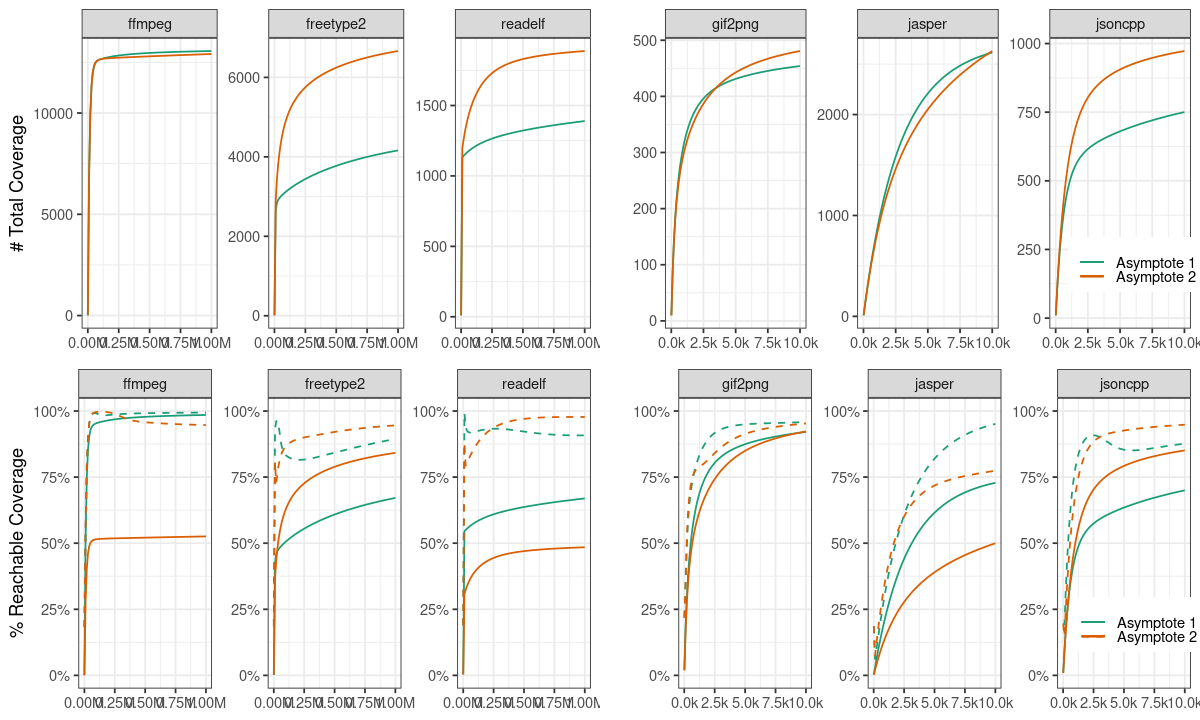

Saving 13.3 x 2.2 in image



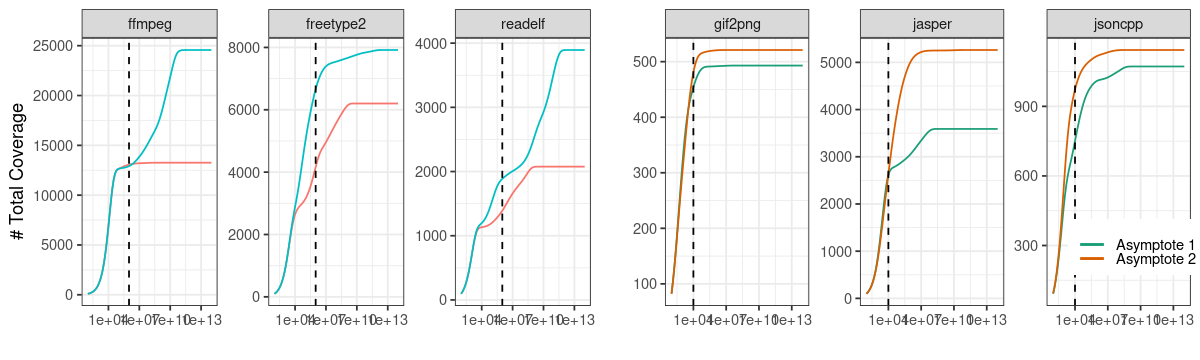

In [13]:
subjects1 = c("ffmpeg","freetype2","readelf")
subjects2 = c("gif2png","jasper","jsoncpp")
datapoints = c(900, 7 * 24 * 3600)

options(repr.plot.width = 10, repr.plot.height = 6)
plot1 = ggplot(subset(species_distribution, subject %in% subjects1))
for (Subject in subjects1) {
  for (Time in datapoints) {
    plot1 = plot1 + geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate,  aes(color=time), args = list(Subject, Time, "Sn"))
  }
}
plot1 = plot1 +
  #scale_x_log10(limits=c(10,10^8)) +
  scale_x_continuous(limits=c(10,10^6), labels=unit_format(unit = "M", scale = 1e-6, sep = "")) +
  scale_y_continuous(name="# Total Coverage") +
  scale_color_brewer(breaks=c("Asymptote 1", "Asymptote 2"),palette = "Dark2") +
  facet_wrap(~subject, scales="free",nrow=1) +
  theme(legend.position="none")

plot2 = ggplot(subset(species_distribution, subject %in% subjects2))
for (Subject in subjects2) {
  for (Time in datapoints) {
    plot2 = plot2 + geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate,  aes(color=time), args = list(Subject, Time, "Sn"))
  }
}
plot2 = plot2 +
  #scale_x_log10(limits=c(10,10^6)) +
  scale_x_continuous(limits=c(10,10^4), labels=unit_format(unit = "k", scale = 1e-3, sep = "")) +
  ylab("") +
  scale_color_brewer(breaks=c("Asymptote 1", "Asymptote 2"),palette = "Dark2") +
  facet_wrap(~subject, scales="free",nrow=1) +
  theme(legend.position = c(0.9, 0.22), legend.title = element_blank(), legend.key.height= unit(0.1, 'cm'))


plot3 = ggplot(subset(species_distribution, subject %in% subjects1))
for (Subject in subjects1) {
  for (Time in datapoints) {
    plot3 = plot3 + 
      geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
        fun = simulate,  aes(color=time), args = list(Subject, Time, "Gn")) +
      geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
        fun = simulate,  aes(color=time), args = list(Subject, Time, "Chao"), linetype="dashed")
  }
}
plot3 = plot3 +
  #scale_x_log10(limits=c(10,10^8)) +
  scale_x_continuous(limits=c(10,10^6), labels=unit_format(unit = "M", scale = 1e-6, sep = "")) +
  scale_y_continuous(limits=c(0,1), name = "% Reachable Coverage", labels=scales::percent) +
  scale_color_brewer(breaks=c("Asymptote 1", "Asymptote 2"),palette = "Dark2") +
  facet_wrap(~subject, scales="free",nrow=1) +
  theme(legend.position="none")


plot4 = ggplot(subset(species_distribution, subject %in% subjects2))
for (Subject in subjects2) {
  for (Time in datapoints) {
    plot4 = plot4 + 
      geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
        fun = simulate,  aes(color=time), args = list(Subject, Time, "Gn")) +
      geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
        fun = simulate,  aes(color=time), args = list(Subject, Time, "Chao"), linetype="dashed")
  }
}
plot4 = plot4 +
  #scale_x_log10(limits=c(10,10^6)) +
  scale_x_continuous(limits=c(10,10^4), labels=unit_format(unit = "k", scale = 1e-3, sep = "")) +
  scale_y_continuous(limits=c(0,1), name = "", labels=scales::percent) +
  scale_color_brewer(breaks=c("Asymptote 1", "Asymptote 2"),palette = "Dark2") +
  facet_wrap(~subject, scales="free",nrow=1) +
  theme(legend.position = c(0.9, 0.22), legend.title = element_blank(), legend.key.height= unit(0.1, 'cm'))

plot5 = ggplot(subset(species_distribution, subject %in% subjects1))
for (Subject in subjects1) {
  for (Time in datapoints) {
    plot5 = plot5 + geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate,  aes(color=time), args = list(Subject, Time, "Sn"))
  }
}
plot5 = plot5 +
  geom_vline(xintercept=10^6, color="black", linetype="dashed") +
  scale_x_log10(limits=c(100,10^14), name="") +
  ylab("# Total Coverage") +
  #scale_y_continuous(limits=c(0,1), name = "% Reachable Coverage", labels=scales::percent) +
  #scale_color_brewer(breaks=c("15 min", "3 hrs", "1 day", "1 week"),palette = "Dark2") +
  facet_wrap(~subject, scales="free",nrow=1) +
  theme(legend.position="none")

ggarrange(plot1, plot2, plot3, plot4, ncol=2, nrow=2)
ggsave("../figures/Figure-7(a).pdf", scale=2, height=2)

options(repr.plot.width = 10, repr.plot.height = 3)
plot6 = ggplot(subset(species_distribution, subject %in% subjects2))
for (Subject in subjects2) {
  for (Time in datapoints) {
    plot6 = plot6 + geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate,  aes(color=time), args = list(Subject, Time, "Sn"))
  }
}
plot6 = plot6 +
  geom_vline(xintercept=10^4, color="black", linetype="dashed") +
  scale_x_log10(limits=c(100,10^14), name="") +
  ylab("")+
  scale_color_brewer(breaks=c("Asymptote 1", "Asymptote 2"),palette = "Dark2") +
  #scale_y_continuous(limits=c(0,1), name = "", labels=scales::percent) +
  facet_wrap(~subject, scales="free",nrow=1) +
  theme(legend.position = c(0.9, 0.22), legend.title = element_blank(), legend.key.height= unit(0.1, 'cm'))


ggarrange(plot5, plot6, ncol=2, nrow=1)

ggsave("../figures/Figure-7(b).pdf", scale=2, height=1.1)


## Motivating Example

We select ```jasper``` as the subject in our motivating example.

* We generate ```Figure-1``` through this code chunk.

Saving 6 x 2.88 in image



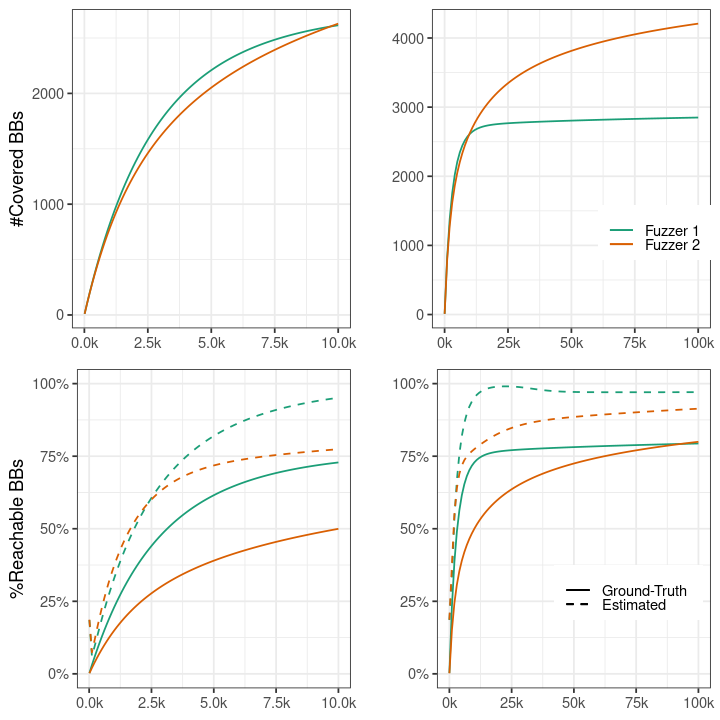

In [14]:
# Execution-order dependent on the above
Subject = "jasper"
datapoints = c(900, 7 * 24 * 3600)
motivating = species_distribution %>% filter(subject == Subject)
options(repr.plot.width = 6, repr.plot.height = 6)

plot1 = ggplot(motivating)
for (Time in datapoints) {
  plot1 = plot1 + 
    geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate,  aes(color=time), args = list(Subject, Time, "Sn"))
}
plot1 = plot1 +
  ylab("#Covered BBs") +
  scale_x_continuous(limits = c(10,10^4), 
                     labels = unit_format(unit = "k", scale = 1e-3, sep = "")) +
  scale_color_brewer(breaks=c("Asymptote 1", "Asymptote 2"),
                     labels=c("Fuzzer 1", "Fuzzer 2"),palette = "Dark2") +
  theme(legend.position="none")

plot2 = ggplot(motivating)
for (Time in datapoints) {
  plot2 = plot2 + 
    geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate,  aes(color = time), args = list(Subject, Time, "Sn"))
}
plot2 = plot2 +
  ylab("") +
  scale_x_continuous(limits = c(10,10^5),
                     labels = unit_format(unit = "k", scale = 1e-3, sep = "")) +
  scale_color_brewer(breaks = c("Asymptote 1", "Asymptote 2"),
                    labels = c("Fuzzer 1", "Fuzzer 2"),palette = "Dark2") +
  theme(legend.position = c(0.8, 0.3),
        legend.title = element_blank(),
        legend.key.height= unit(0.1, "cm"))

plot3 = ggplot(motivating)
for (Time in datapoints) {
  plot3 = plot3 + 
    geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate, args = list(Subject, Time, "Gn"),
      aes(color = time, linetype = "Ground-Truth")) +
    geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate, args = list(Subject, Time, "Chao"),
      aes(color=time, linetype = "Estimated"))
}
plot3 = plot3 +
  scale_y_continuous(limits=c(0,1), name = "%Reachable BBs", labels=scales::percent) +
  scale_x_continuous(limits = c(10,10^4), 
                     labels = unit_format(unit = "k", scale = 1e-3, sep = "")) +
  scale_color_brewer(breaks=c("Asymptote 1", "Asymptote 2"),
                     labels=c("Fuzzer 1", "Fuzzer 2"),palette = "Dark2") +
  scale_linetype_manual(breaks = c("Ground-Truth","Estimated"),
                        values = c("solid","dashed")) +
  theme(legend.position="none")

plot4 = ggplot(motivating)
for (Time in datapoints) {
  plot4 = plot4 + 
    geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate, args = list(Subject, Time, "Gn"),
      aes(color = time, linetype = "Ground-Truth")) +
    geom_function(data = data.frame(subject = Subject, time = time2text(Time)),
      fun = simulate, args = list(Subject, Time, "Chao"),
      aes(color=time, linetype = "Estimated"))
}
plot4 = plot4 +
  ylab("") +
  scale_y_continuous(limits=c(0,1), name = "", labels=scales::percent) +
  scale_x_continuous(limits = c(10,10^5),
                     labels = unit_format(unit = "k", scale = 1e-3, sep = "")) +
  scale_color_brewer(breaks = c("Asymptote 1", "Asymptote 2"),
                    labels = c("Fuzzer 1", "Fuzzer 2"),palette = "Dark2") +
  scale_linetype_manual(breaks = c("Ground-Truth","Estimated"),
                        values = c("solid","dashed")) +
  guides(colour = "none") +
  theme(legend.position = c(0.7, 0.3),
        legend.title = element_blank(),
        legend.key.height= unit(0.1, "cm"))

ggarrange(plot1, plot2, plot3, plot4, nrow = 2, ncol = 2)
ggsave("../figures/Figure-1.pdf", scale = 0.9, height = 3.2)

## Simulation: d0 and d1 for the uniform distribution

Here we show that d1 is negative for the entire period of d0<0.

* We generate the ```Figure-9``` through a fuzzing simulation here.

In [15]:
S <- 1000

data <- data.frame()

for (n in seq(1, 7000)) {
    data <- bind_rows(
        data,
        data.frame(
            n = n,
            d_0 = S * (1 - (n / (S - 1))) * (1 - (1 / S)) ^ n,
            d_1 = (1 - ((n - 1) / ((2 * S) - 2))) * n * (1 - (1 / S)) ^ (n - 1)
        )
    )
}

head(data)

,n,d_0,d_1
,<int>,<dbl>,<dbl>
1,1,998.0000,1.000000
2,2,996.0030,1.997000
3,3,994.0090,2.991006
4,4,992.0180,3.982024
5,5,990.0300,4.970060
6,6,988.0449,5.955120


Saving 4.67 x 2.1 in image



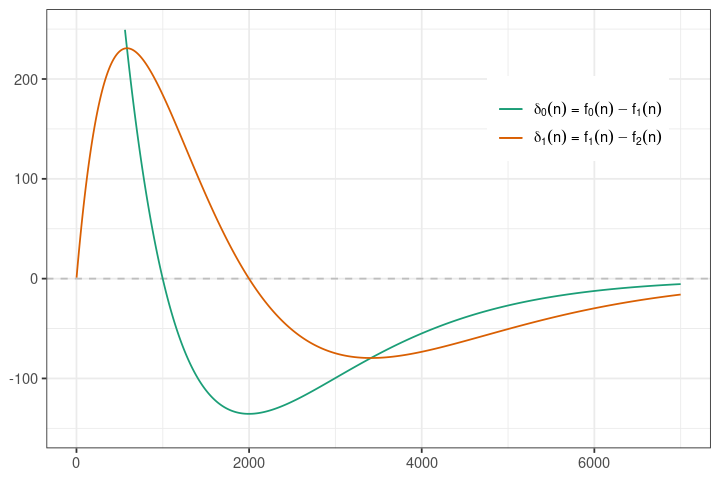

In [16]:
legend <- list(
    `d_0` = expression(delta[0](n) ~ "=" ~ f[0](n) - f[1](n)),
    `d_1` = expression(delta[1](n) ~ "=" ~ f[1](n) - f[2](n))
)

# Plot the result
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(data) +
    geom_hline(yintercept = 0, color = "grey", linetype = "dashed") +
    geom_line(aes(x = n, y = d_0, color = "d_0")) +
    geom_line(aes(x = n, y = d_1, color = "d_1")) +
    ylim(-150, 250) +
    scale_color_brewer(labels = legend, palette="Dark2") +
    theme(legend.position=c(0.8,0.75),
          axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          legend.title=element_blank())

ggsave("../figures/Figure-9.pdf", scale = 0.7, height = 3)

## RQ4: Stopping Rule

The plots for RQ4 are generated here.

* The resulting figure is the ```Figure-8``` in the paper.

Saving 13.3 x 8.2 in image



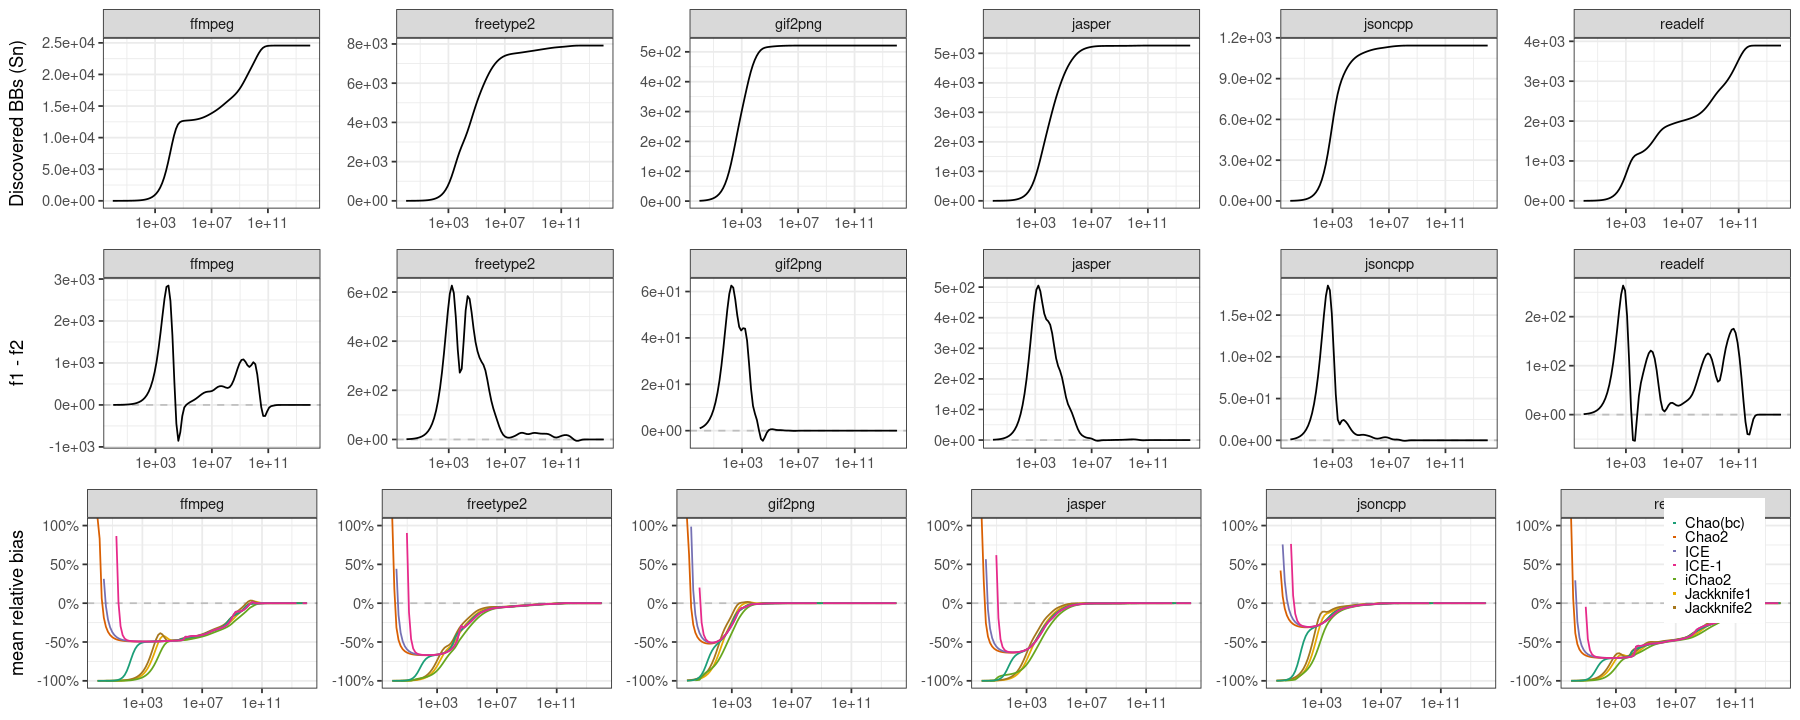

In [17]:
# Function to simlate fuzzers through resampling and estimate effectiveness.
options(repr.plot.width = 15, repr.plot.height = 6)
simulate = function(n, Subject, Time, Type) {
  t = species_distribution %>%
    filter(subject == Subject & time == Time)
  S = sum(t$pi > 0)

  if (Type == "Sn") {
    return(sapply(n, function(m) {
      return(S - sum((1 - t$pi)^m))
    }))
  }
  if (Type == "f0") {
    max_f1 = max(sapply(n, function(m) {return(m * sum(t$pi * (1 - t$pi)^(m - 1)))}))
    return(sapply(n, function(m) {
      f0 = sum((1 - t$pi)^m)
      return(ifelse(TRUE, f0, NA))
    }))
  }
  if (Type == "jk1") {
    return(sapply(n, function(m) {
      f0 = sum((1 - t$pi)^m)
      f1 = m * sum(t$pi * (1 - t$pi)^(m - 1))
      return((f1 - f0)/S)
    }))
  }
    
  if (Type == "jk2") {
    return(sapply(n, function(m) {
      f0 = sum((1 - t$pi)^m)
      f1 = m * sum(t$pi * (1 - t$pi)^(m - 1))
      f2 = m * (m - 1) / 2 * sum((t$pi^2) * (1 - t$pi)^(m - 2))
      jk2 = 2*f1-f2
      return((jk2 - f0)/S)
    }))
  }

  if (Type == "f2") {
    return(sapply(n, function(m) {
      return(m * (m - 1) / 2 * sum(t$pi * t$pi * (1 - t$pi)^(m-2)))
    }))
  }
  if (Type == "chao") {
    max_f1 = max(sapply(n, function(m) {return(m * sum(t$pi * (1 - t$pi)^(m - 1)))}))
    return(sapply(n, function(m) {
      f0 = sum((1 - t$pi)^m)
      f1 = m * sum(t$pi * (1 - t$pi)^(m - 1))
      f2 = m * (m - 1) / 2 * sum((t$pi^2) * (1 - t$pi)^(m - 2))
      chao = (f1^2) / (2 * f2)
      return((chao - f0)/S)
    }))
  }
  if (Type == "ichao") {
    max_f1 = max(sapply(n, function(m) {return(m * sum(t$pi * (1 - t$pi)^(m - 1)))}))
    return(sapply(n, function(m) {
      f0 = sum((1 - t$pi)^m)
      f1 = m * sum(t$pi * (1 - t$pi)^(m - 1))
      f2 = m * (m - 1) / 2 * sum((t$pi^2) * (1 - t$pi)^(m - 2))
      f3 = choose(m,3)* sum((t$pi^3) * (1 - t$pi)^(m - 3))
      f4 = choose(m,4)* sum((t$pi^4) * (1 - t$pi)^(m - 4))
      ichao = ifelse(f2==0,((n-1)/n)*((f1*(f1-1))/2),((n-1)/n)*((f1^2)/(2*f2))) +
        (f3/(4*f4))*max((f1-((f2*f3)/(2*f4))),0)
      return((ichao - f0)/S)
    }))
  }
  if (Type == "chao_bc") {
    max_f1 = max(sapply(n, function(m) {return(m * sum(t$pi * (1 - t$pi)^(m - 1)))}))
    return(sapply(n, function(m) {
      f0 = sum((1 - t$pi)^m)
      f1 = m * sum(t$pi * (1 - t$pi)^(m - 1))
      f2 = m * (m - 1) / 2 * sum((t$pi^2) * (1 - t$pi)^(m - 2))
      chao_bc = ((f1*(f1-1))/(2*(f2+1)))
      return((chao_bc - f0)/S)
    }))
  }
  if (Type == "ice") {
    max_f1 = max(sapply(n, function(m) {return(m * sum(t$pi * (1 - t$pi)^(m - 1)))}))
    return(sapply(n, function(m) {
      f0 = sum((1 - t$pi)^m)
      Sn = S - f0
      f1 = m * sum(t$pi * (1 - t$pi)^(m - 1))
      f2 = m * (m - 1) / 2 * sum((t$pi^2) * (1 - t$pi)^(m - 2))
      f3 = choose(m,3)* sum((t$pi^3) * (1 - t$pi)^(m - 3))
      f4 = choose(m,4)* sum((t$pi^4) * (1 - t$pi)^(m - 4))
      f5 = choose(m,5)* sum((t$pi^5) * (1 - t$pi)^(m - 5))
      f6 = choose(m,6)* sum((t$pi^6) * (1 - t$pi)^(m - 6))
      f7 = choose(m,7)* sum((t$pi^7) * (1 - t$pi)^(m - 7))
      f8 = choose(m,8)* sum((t$pi^8) * (1 - t$pi)^(m - 8))
      f9 = choose(m,9)* sum((t$pi^9) * (1 - t$pi)^(m - 9))
      f10 = choose(m,10)* sum((t$pi^10) * (1 - t$pi)^(m - 10))
      
      Sinfr = f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10
      Sfreq = Sn - Sinfr
      ninfr = 1 * f1 + 2 * f2 + 3 * f3 + 4 * f4 +  5 * f5 +
              6 * f6 + 7 * f7 + 8 * f8 + 9 * f9 + 10 * f10
      CICE  = 1 - ifelse(ninfr == 0, 0, f1 / ninfr)
      sum1  =  2 * f2 +  6 * f3 + 12 * f4 + 20 * f5 + 
             30 * f6 + 42 * f7 + 56 * f8 + 72 * f9 + 90 * f10
      gamma = ifelse(CICE == 0 | ninfr == 0 | sum1 == 0, 0,
             Sinfr / CICE * ninfr / (ninfr - 1) * sum1 / (ninfr * ninfr) - 1)
      gamma = ifelse(gamma < 0, 0, gamma)
      SICE  = Sfreq + Sinfr / CICE + f1 / CICE * gamma
      return((SICE - S)/S)
    }))
  }
    if (Type == "ice_1") {
    max_f1 = max(sapply(n, function(m) {return(m * sum(t$pi * (1 - t$pi)^(m - 1)))}))
    return(sapply(n, function(m) {
      f0 = sum((1 - t$pi)^m)
      Sn = S - f0
      f1 = m * sum(t$pi * (1 - t$pi)^(m - 1))
      f2 = m * (m - 1) / 2 * sum((t$pi^2) * (1 - t$pi)^(m - 2))
      f3 = choose(m,3)* sum((t$pi^3) * (1 - t$pi)^(m - 3))
      f4 = choose(m,4)* sum((t$pi^4) * (1 - t$pi)^(m - 4))
      f5 = choose(m,5)* sum((t$pi^5) * (1 - t$pi)^(m - 5))
      f6 = choose(m,6)* sum((t$pi^6) * (1 - t$pi)^(m - 6))
      f7 = choose(m,7)* sum((t$pi^7) * (1 - t$pi)^(m - 7))
      f8 = choose(m,8)* sum((t$pi^8) * (1 - t$pi)^(m - 8))
      f9 = choose(m,9)* sum((t$pi^9) * (1 - t$pi)^(m - 9))
      f10 = choose(m,10)* sum((t$pi^10) * (1 - t$pi)^(m - 10))
      
      Sinfr = f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10
      Sfreq = Sn - Sinfr
      ninfr = 1 * f1 + 2 * f2 + 3 * f3 + 4 * f4 +  5 * f5 +
              6 * f6 + 7 * f7 + 8 * f8 + 9 * f9 + 10 * f10
      CICE  = 1 - ifelse(ninfr == 0, 0, f1 / ninfr)
      sum1  =  2 * f2 +  6 * f3 + 12 * f4 + 20 * f5 + 
             30 * f6 + 42 * f7 + 56 * f8 + 72 * f9 + 90 * f10
      gamma = ifelse(CICE == 0 | ninfr == 0 | sum1 == 0, 0,
             Sinfr / CICE * ninfr / (ninfr - 1) * sum1 / (ninfr * ninfr) - 1)
      gamma = ifelse(gamma < 0, 0, gamma)

      gamma_curl = ifelse(CICE == 0 | ninfr == 0 | sum1 == 0, 0,
      gamma * (1 + (ninfr * (1 - CICE)) / (ninfr * (ninfr - 1) * CICE)))
      gamma_curl = ifelse(gamma_curl < 0, 0, gamma_curl)
      SICE1 = Sfreq + Sinfr / CICE + f1 / CICE * gamma_curl
      return((SICE1 - S)/S)
    }))
  }
  if (Type == "d1") {
    return(sapply(n, function(m) {
      f1 = m * sum(t$pi * (1 - t$pi)^(m - 1))
      f2 = choose(m, 2) * sum((t$pi^2) * (1 - t$pi)^(m - 2))
      return(f1 - f2)
    }))
  }
}

Time = 7 * 24 * 3600
plot1 = ggplot(species_distribution) +
  geom_hline(yintercept=0, linetype="dashed", color="grey")
  
for (Subject in levels(factor(species_distribution$subject))) {
  plot1 = plot1 + 
    geom_function(data = data.frame(subject = Subject, type = "d1"),
      fun = simulate, args = list(Subject, Time, "d1"))
}
plot1 = plot1 +
  scale_x_log10(limits=c(1,10^14)) +
  scale_y_continuous(labels = function(x) format(x, scientific = TRUE, width=9), name="f1 - f2") +
  facet_wrap(~subject, nrow=1, scales="free")

plot2 = ggplot(species_distribution) +
  geom_hline(yintercept=0, linetype="dashed", color="grey")
  
for (Subject in levels(factor(species_distribution$subject))) {
  plot2 = plot2 + 
    #geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
    #  fun = simulate, aes(color="estimand f0"), args = list(Subject, Time, "f0")) +
    geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
      fun = simulate, aes(color="Jackknife1"), args = list(Subject, Time, "jk1")) +
    geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
      fun = simulate, aes(color="Jackknife2"), args = list(Subject, Time, "jk2")) +
    geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
      fun = simulate, aes(color="Chao2"), args = list(Subject, Time, "chao")) +
    geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
      fun = simulate, aes(color="iChao2"), args = list(Subject, Time, "ichao")) +
    geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
      fun = simulate, aes(color="Chao(bc)"), args = list(Subject, Time, "chao_bc")) +
    geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
      fun = simulate, aes(color="ICE"), args = list(Subject, Time, "ice")) +
    geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
      fun = simulate, aes(color="ICE-1"), args = list(Subject, Time, "ice_1"))
}

plot2 = plot2 + 
  scale_x_log10(limits=c(1,10^14)) +
  scale_y_continuous(labels=scales::percent ,name="mean relative bias",limits=c(-1,1)) +
  #scale_color_manual(values=c("blue","darkgreen")) +
  facet_wrap(~subject, nrow=1, scales="free") +
  theme(legend.title = element_blank(), legend.position = c(0.955,0.75), legend.key.size = unit(0.7, "mm")) + 
  scale_color_brewer(palette = "Dark2")+
  guides(color = guide_legend(override.aes = list(size = 0.5)))
  
                     
plot3 = ggplot(species_distribution) +
  geom_hline(yintercept=0, linetype="dashed", color="grey")
  
for (Subject in levels(factor(species_distribution$subject))) {
  plot3 = plot3 + 
    #geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
    #  fun = simulate, aes(color="estimand f0"), args = list(Subject, Time, "f0")) +
    geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
      fun = simulate, aes(color="Jacknife1"), args = list(Subject, Time, "jk1")) +
    geom_function(data = data.frame(subject = Subject, type = "f0/f1"),
      fun = simulate, aes(color="Chao2"), args = list(Subject, Time, "chao")) 
}

plot3 = plot3 + 
  #geom_polygon(data=avg_data, aes(x=n,))
  scale_x_log10(limits=c(1,10^14)) +
  scale_y_continuous(labels = function(x) format(x, scientific = TRUE, width=9), name="mean relative bias",limits=c(-1,1)) +
  #scale_color_manual(values=c("blue","darkgreen")) +
  facet_wrap(~subject, nrow=1, scales="free") +
  theme(legend.position = c(0.955, 0.18), legend.title = element_blank()) + 
  scale_color_brewer(palette = "Dark2")


plot0 = ggplot(species_distribution)
for (Subject in levels(factor(species_distribution$subject))) {
  plot0 = plot0 + 
    geom_function(data = data.frame(subject = Subject, type = "Sn"),
      fun = simulate, args = list(Subject, Time, "Sn"))
}
plot0 = plot0 +
  scale_x_log10(limits=c(1,10^14)) +
  scale_y_continuous(labels = function(x) format(x, scientific = TRUE, width=9), name="Discovered BBs (Sn)") +
  facet_wrap(~subject, nrow=1, scales="free")

ggarrange(plot0, plot1, plot2, ncol = 1)
ggsave("../figures/Figure-8.pdf",scale=2,height=4.1)

## Compute Campaign Length to Realize False Peaks

In [18]:
# We use the 'fuzztastic2' data frame from Part 1
load(file="../data/fuzztastic_data.Rda")

# We also use the 'species_distribution' data frame and 'simulate' function to reshape data.

Compute f1-f2 and time to realize false peak for blackbox simulation

In [19]:
# Compute d1=f1-f2
diff_data = tibble()
N=10^14
for(subject in levels(factor(fuzztastic2$subject))){
    diff_data = rbind(diff_data,
                     tibble(n = c(1.2^seq(0,log2(N)/log2(1.2)),N),
                            d1 = sapply(n,simulate,Subject=subject, Time, Type="d1"),
                            Sn = sapply(n,simulate,Subject=subject, Time, Type="Sn"),
                            subject = subject))
    
}

In [20]:
# Compute points where f1-f2 go negative
avg_data = tibble()
for(sub in levels(factor(fuzztastic2$subject))){
    n = c(1.2^seq(0,log2(N)/log2(1.2)),N)
    k = 1
    while(k <= length(n)){
        val = (diff_data %>% filter(subject==sub & n==n[k]))$d1
        if(val<0 & !is.na(val)){
            temp = diff_data %>% filter(subject==sub & n>n[k])
            count=0
            if(nrow(temp>0)){
                for(i in 1:nrow(temp)){
                    if(temp[i,]$d1<0 & !is.na(temp[i,]$d1)){
                        count = count + 1
                    } else{
                        break
                    }
                }
            }
            avg_data = rbind(avg_data,tibble(n = n[k],
                                 d1 = (diff_data %>% filter(subject==sub & n==n[k]))$d1,
                                 n_end = (diff_data %>% filter(subject==sub & n==n[k+count]))$n,
                                 asymptote_at = (diff_data %>% filter(subject==sub) %>% filter(Sn==max(Sn)))$n[1],
                                 subject=sub))
            k = k + count + 1
        }else{
            k = k + 1
        }
    }
}

avg_data = avg_data %>% mutate(n1 = asymptote_at-n_end, how_long = (n_end-n)/n)

head(avg_data,10)

n,d1,n_end,asymptote_at,subject,n1,how_long
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
2.717376e+04,-170.16508820,1.402106e+05,1.875397e+12,ffmpeg,1.875397e+12,4.159780
3.397080e+10,-115.85742746,3.467313e+13,1.875397e+12,ffmpeg,-3.279774e+13,1019.674700
7.536799e+11,-0.31814342,1.000000e+14,1.672122e+13,freetype2,-8.327878e+13,131.682331
1.887067e+04,-2.04327197,6.761702e+04,4.792707e+07,gif2png,4.785945e+07,2.583181
3.110729e+06,-0.01759213,1.063315e+09,4.792707e+07,gif2png,-1.015388e+09,340.821892
1.926081e+07,-1.30646235,2.060776e+08,4.361573e+11,jasper,4.359512e+11,9.699321
2.830900e+10,-0.08134785,8.063862e+12,4.361573e+11,jasper,-7.627705e+12,283.851577
8.281797e+07,-0.22121906,2.359083e+10,1.275978e+09,jsoncpp,-2.231485e+10,283.851577
2.539765e+03,-12.90269819,5.266457e+03,8.063862e+12,readelf,8.063862e+12,1.073600


## Compute Probabilities of False Peaks 

In [21]:
# Get the species distribution for each run
species_dist_run = fuzztastic2 %>%
  mutate(hits = hits - 8) %>% # account for calibration phase
  filter(hits > 0) %>%
  group_by(subject, time, run) %>%
  mutate(pi = hits / sum(hits)) # probability within run

In [22]:
# Simulate blackbox fuzzers for each fuzzer run
simulate_run = function(n, Subject, Trial, Time, Type) {
  tt = species_dist_run %>%
    filter(subject == Subject & time == Time & run==Trial)
  S = sum(tt$pi > 0)

  if (Type == "Sn") {
    return(sapply(n, function(m) {
      return(S - sum((1 - tt$pi)^m))
    }))
  }
  if (Type == "f0") {
    return(sapply(n, function(m) {
      return(sum((1 - tt$pi)^m))
    }))
  }
  if (Type == "f1") {
    return(sapply(n, function(m) {
      return(m * sum(tt$pi * (1 - tt$pi)^(m-1)))
    }))
  }
  if (Type == "f2") {
    return(sapply(n, function(m) {
      return(m * (m - 1) / 2 * sum(tt$pi * tt$pi * (1 - tt$pi)^(m-2)))
    }))
  }
  if (Type == "d1") {
    return(sapply(n, function(m) {
      return(m * sum(tt$pi * (1 - tt$pi)^(m-1)) - m * (m - 1) / 2 * sum(tt$pi * tt$pi * (1 - tt$pi)^(m-2)))
    }))
  }
}

In [24]:
# Compute d1=f1-f2
REGENERATE_DATA = FALSE
if (REGENERATE_DATA ) {
    diff_data_run = tibble()
    N=10^14
    Time = 7 * 24 * 3600
        for(subject in levels(factor(fuzztastic2$subject))){
        for(trial in unique(as.numeric((fuzztastic2 %>% filter(subject==subject))$run))){
            diff_data_run = rbind(diff_data_run,
                             tibble(n = c(1.2^seq(0,log2(N)/log2(1.2)),N),
                                    d1 = sapply(n,simulate_run, Subject=subject, Trial=trial, Time=Time, Type="d1"),
                                    Sn = sapply(n,simulate_run, Subject=subject, Trial=trial, Time=Time, Type="Sn"),
                                    subject = subject,
                                    run = trial))
        }
    }
    save(diff_data_run, file="../data/run_wise_d1.Rda")

    } else {

    load(file="../data/run_wise_d1.Rda")

}

In [25]:
# Compute points where f1-f2 go negative
run_data = tibble()
for(sub in levels(factor(fuzztastic2$subject))){
    for(trial in unique(as.numeric((fuzztastic2 %>% filter(subject==sub))$run))){
        n = c(1.2^seq(0,log2(N)/log2(1.2)),N)
        k = 1
        while(k <= length(n)){
            val = (diff_data_run %>% filter(subject==sub & run==trial & n==n[k]))$d1
            if(val<0 & !is.na(val)){
                temp = diff_data_run %>% filter(subject==sub & run==trial & n>n[k])
                count=0
                if(nrow(temp>0)){
                    for(i in 1:nrow(temp)){
                        if(temp[i,]$d1<0 & !is.na(temp[i,]$d1)){
                            count = count + 1
                        } else{
                            break
                        }
                    }
                }
                run_data = rbind(run_data,tibble(n = n[k],
                                 d1 = (diff_data_run %>% filter(subject==sub & run==trial & n==n[k]))$d1,
                                 n_end = (diff_data_run %>% filter(subject==sub  & run==trial& n==n[k+count]))$n,
                                 asymptote_at = (diff_data_run %>% filter(subject==sub & run==trial) %>% filter(Sn==max(Sn)))$n[1],
                                 subject=sub,
                                 run = trial))
                k = k + count + 1
            }else{
                k = k + 1
            }
        }
    }
}

run_data = run_data %>% mutate(n1 = asymptote_at-n_end, how_long = (n_end-n)/n)

head(run_data)

n,d1,n_end,asymptote_at,subject,run,n1,how_long
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2.717376e+04,-134.271697,1.402106e+05,1.875397e+12,ffmpeg,1,1.875397e+12,4.159780
3.810051e+09,-3.407492,2.830900e+10,1.875397e+12,ffmpeg,1,1.847088e+12,6.430084
1.217235e+11,-3.275607,3.467313e+13,1.875397e+12,ffmpeg,1,-3.279774e+13,283.851577
2.717376e+04,-172.538130,1.402106e+05,1.875397e+12,ffmpeg,2,1.875397e+12,4.159780
6.583768e+09,-0.642969,1.638252e+10,1.875397e+12,ffmpeg,2,1.859014e+12,1.488320
1.217235e+11,-5.131546,3.467313e+13,1.875397e+12,ffmpeg,2,-3.279774e+13,283.851577


In [26]:
# Join average campaign data to individual runs
comparison = diff_data_run %>% left_join(y=diff_data, by = c("subject","n"), all.x=T)

head(comparison)

n,d1.x,Sn.x,subject,run,d1.y,Sn.y
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1.00000,1.000000,1.000000,ffmpeg,1,1.000000,1.000000
1.20000,1.199971,1.199990,ffmpeg,1,1.199971,1.199990
1.44000,1.439923,1.439974,ffmpeg,1,1.439923,1.439974
1.72800,1.727847,1.727949,ffmpeg,1,1.727848,1.727949
2.07360,2.073329,2.073510,ffmpeg,1,2.073331,2.073510
2.48832,2.487869,2.488170,ffmpeg,1,2.487872,2.488171


In [27]:
# Compute probabilities where d1<0 for an individual run but d1>0 for average run
prob_data = comparison %>%
                group_by(subject,run) %>%
                filter(d1.x<0) %>%
                count(status = d1.y>0) %>%
                mutate(status=ifelse(status==TRUE,1,0)) %>%
                ungroup() %>%
                complete(subject,status,run,fill=list(n=0)) %>%
                group_by(subject,run) %>%
                mutate(prob = n[status==TRUE]/sum(n)) %>%
                select(subject,run,prob) %>% distinct()

tail(prob_data)

subject,run,prob
<chr>,<dbl>,<dbl>
readelf,25,0.02564103
readelf,26,0.02631579
readelf,27,0.05000000
readelf,28,0.00000000
readelf,29,0.02564103
readelf,30,0.00000000


* We generate the ```Figure-10``` in the paper below.

Saving 5.33 x 2.8 in image



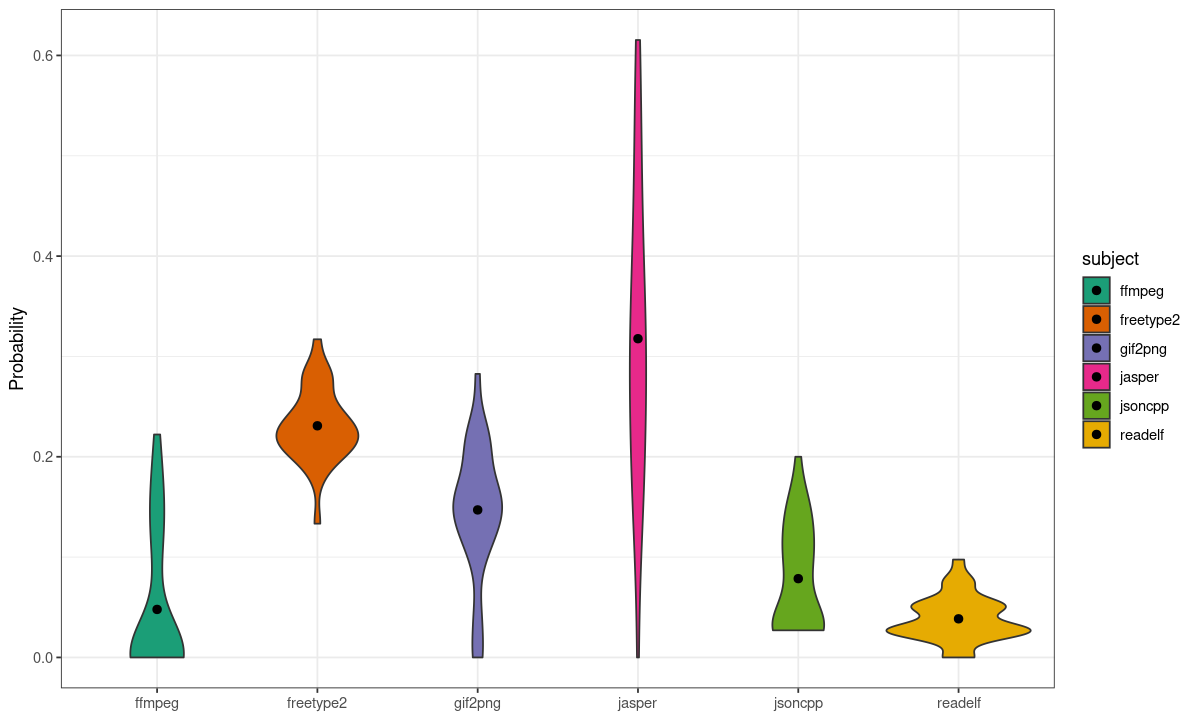

In [28]:
# Violin plot for probabilities
options(repr.plot.width = 10, repr.plot.height = 6)
p = prob_data %>%
    ggplot(aes(subject,prob,fill=subject),trim=FALSE) +
    geom_violin() +
    scale_fill_brewer(palette="Dark2") +
    ylab("Probability") +
    stat_summary(fun=mean, geom="point", size=2, color="black") +
    theme(axis.title.x=element_blank(),)

p
ggsave("../figures/Figure-10.pdf",p, height=3.5, scale=0.8)